In [1]:
include("../src/GaPSE.jl");

In [2]:
using DelimitedFiles, Plots, Dierckx, QuadGK, SpecialFunctions, TwoFAST, LaTeXStrings


In [3]:
FILE_F_MAP = "../data/F_REFERENCE.txt"
#FILE_PS = "../data/WideA_ZA_pk.dat"
FILE_PS = "file_pk.txt"
FILE_BACKGROUND = "../data/WideA_ZA_background.dat"
#FILE_IS = "tab_xi.txt"

z_min = 0.05
z_max = 0.20
θ_max = π / 2.0
params = GaPSE.CosmoParams(z_min, z_max, θ_max;
  k_min = 1e-8, k_max = 1000.0,
  Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70)
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP)#, FILE_IS)

GaPSE.parameters_used(stdout, cosmo)

kmin = 1.0e-8
kmax = 1000.0
s0 = 0.001
# The following parameters were used for this computation: 
# CLASS Power Spectrum input file : "file_pk.txt"
# F window function input file : "../data/F_REFERENCE.txt"
# CLASS Background input file: "../data/WideA_ZA_background.dat"
# 	 z_min = 0.05 	 z_max = 0.2
# 	 k_min = 1.0e-8 	 k_max = 1000.0
# 	 h_0 = 0.7 	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
# 	 comoving s_min = 148.1920001343431 Mpc/h_0
# 	 comoving s_max = 571.7022420911966 Mpc/h_0
# 	 comoving s_eff = 435.37470960794167 Mpc/h_0
# 	 comoving z_eff = 0.15045636097417317 
# 	 Volume of the survey V_survey = 3.845366169354268e8
# 	 σ_0 = 102.96223036655405
# 	 σ_1 = 16.19435120785869
# 	 σ_2 = 100.90502766576651
# 	 σ_3 = 102.96223036655405
# 


In [4]:
tab_pk = readdlm("../data/WideA_ZA_pk.dat", comments=true);
ks = convert(Vector{Float64}, tab_pk[:,1]);
k_min, k_max = ks[begin], ks[end]
pks = convert(Vector{Float64}, tab_pk[:,2]);
PK = Spline1D(ks, pks);

In [5]:
tab_casto_Is = readdlm("tab_xi.txt", comments=true);
casto_ss = convert(Vector{Float64}, tab_casto_Is[2:end,1]);

In [6]:
kmin = min(ks...)
kmax = 10.
σ_0, σ_0_err  = quadgk(q -> PK(q) * q^2 / (2 * π^2), kmin, kmax)
σ_1, σ_1_err = quadgk(q -> PK(q) * q / (2 * π^2), kmin, kmax)
σ_2, σ_2_err = quadgk(q -> PK(q) / (2 * π^2), kmin, kmax)
σ_3, σ_3_err = quadgk(q -> PK(q) / (2 * π^2 * q), kmin, kmax)

println("σ_0 = $σ_0 \t σ_0_err = $σ_0_err")
println("σ_1 = $σ_1 \t σ_1_err = $σ_1_err")
println("σ_2 = $σ_2 \t σ_2_err = $σ_2_err")
println("σ_3 = $σ_3 \t σ_3_err = $σ_3_err")

σ_0 = 18.584280735800895 	 σ_0_err = 2.7176219709323934e-7
σ_1 = 15.755562804134984 	 σ_1_err = 2.2202217648398248e-7
σ_2 = 101.06362213588237 	 σ_2_err = 1.4978881322947474e-6
σ_3 = 3735.1445439219237 	 σ_3_err = 4.569273746514446e-5


In [7]:
function I_l_n(s, PK; l=0, n=0)
    quadgk(q -> sphericalbesselj(l, s*q) *PK(q) * q^2 / (2 * π^2) / (q*s)^n, kmin, kmax)
end

I_l_n (generic function with 1 method)

In [8]:
#ss = 10 .^ range(-6, 2, 100);
ss = casto_ss;

In [9]:
my_I00s = [cosmo.tools.I00(s) for s in ss];
my_I20s = [cosmo.tools.I20(s) for s in ss];
my_I40s = [cosmo.tools.I40(s) for s in ss];
my_I02s = [cosmo.tools.I02(s) for s in ss];
my_I22s = [cosmo.tools.I22(s) for s in ss];
my_I31s = [cosmo.tools.I31(s) for s in ss];
my_I13s = [cosmo.tools.I13(s) for s in ss];
my_I11s = [cosmo.tools.I11(s) for s in ss];

In [10]:
#=
true_I00s = [I_l_n(s, PK; l=0, n=0)[1] for s in ss];
true_I20s = [I_l_n(s, PK; l=2, n=0)[1] for s in ss];
true_I40s = [I_l_n(s, PK; l=4, n=0)[1] for s in ss];
true_I02s = [I_l_n(s, PK; l=0, n=2)[1] for s in ss];
true_I22s = [I_l_n(s, PK; l=2, n=2)[1] for s in ss];
true_I31s = [I_l_n(s, PK; l=3, n=1)[1] for s in ss];
true_I13s = [I_l_n(s, PK; l=1, n=3)[1] for s in ss];
true_I11s = [I_l_n(s, PK; l=1, n=1)[1] for s in ss];
=#

In [11]:
casto_I00s = convert(Vector{Float64}, tab_casto_Is[2:end,2]);
casto_I20s = convert(Vector{Float64}, tab_casto_Is[2:end,3]);
casto_I40s = convert(Vector{Float64}, tab_casto_Is[2:end,4]);
casto_I02s = convert(Vector{Float64}, tab_casto_Is[2:end,5]) ./ casto_ss .^2;
casto_I22s = convert(Vector{Float64}, tab_casto_Is[2:end,6]) ./ casto_ss .^2;
casto_I31s = convert(Vector{Float64}, tab_casto_Is[2:end,7]) ./ casto_ss;
casto_I11s = convert(Vector{Float64}, tab_casto_Is[2:end,8]) ./ casto_ss;

In [12]:
my_vec = [my_I00s, my_I20s, my_I40s, my_I02s, my_I22s, my_I31s,
             my_I11s, my_I13s];
casto_vec = [casto_I00s, casto_I20s, casto_I40s, casto_I02s, casto_I22s, 
            casto_I31s, casto_I11s ];
;
#=
true_vec = [true_I00s, true_I20s, true_I40s, true_I02s, true_I22s, true_I31s,
            true_I13s, true_I11s, true_I13s];
=#

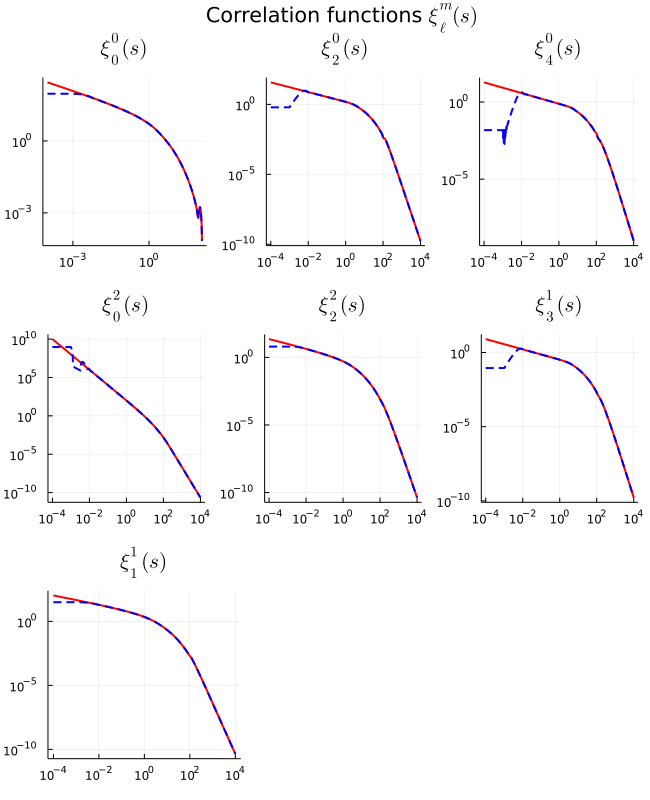

In [13]:
ξs_names = [L"$\xi_{0}^{0}(s)$", L"$\xi_{2}^{0}(s)$", L"$\xi_{4}^{0}(s)$",
            L"$\xi_{0}^{2}(s)$", L"$\xi_{2}^{2}(s)$", L"$\xi_{3}^{1}(s)$",
            L"$\xi_{1}^{1}(s)$"]
ps = [plot() for i in 1:7]

title = plot(title = "Correlation functions "* L"$\xi_\ell^m(s)$", grid=false, showaxis = false, bottom_margin = -50Plots.px, ticks=false)
xs = ss
for i in 1:7
    c_ys = casto_vec[i]
    m_ys = my_vec[i]
    ps[i] = plot([xs[c_ys.>0], xs[m_ys.>0]], [c_ys[c_ys.>0], m_ys[m_ys.>0] ], 
        lw=2, lc=["red" "blue"], ls=[:solid :dash],
        title=ξs_names[i], legend=false,
        xaxis=:log, yaxis=:log)
end

l = @layout [A{0.05h}; a b c ; d e f; g _ _ ]
plot(title, ps..., layout=l, size=(650,800))

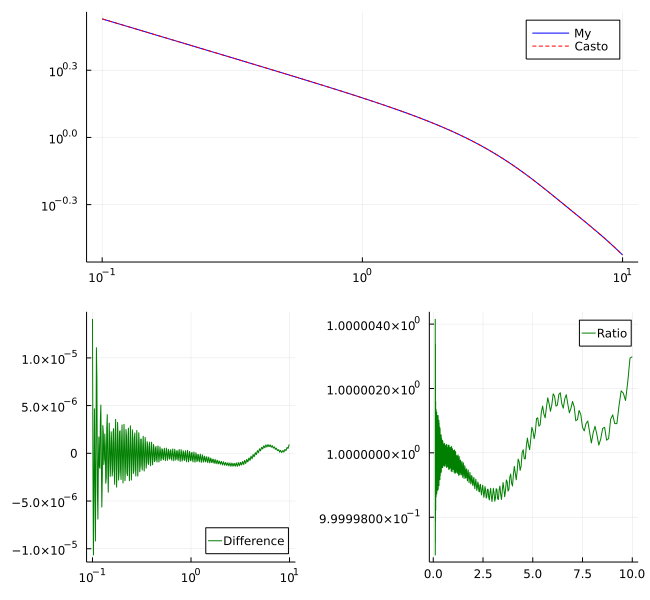

In [14]:
ind = 2

x_min = 1e-1
x_max = 10

new_ss = ss[x_min.< ss .< x_max]
my_ys = my_vec[ind][x_min.< ss .< x_max]
casto_ys = casto_vec[ind][x_min.< ss .< x_max]

p1 = plot([new_ss, new_ss], [my_ys, casto_ys], 
    xscale=:log10, yscale=:log10,
    label=["My" "Casto"], lc=[:blue :red], ls=[:solid :dash])
p2 = plot(new_ss, casto_ys .- my_ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(new_ss, casto_ys ./ my_ys, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

In [15]:
#=
ind = 1
spline = Spline1D(ss,  true_vec[ind])
p1 = plot([ss, ss, ss], [my_vec[ind], true_vec[ind], casto_vec[ind]], 
    xscale=:log10, yscale=:log10,
    label=["My" "True" "Casto"], lc=[:blue :green :red])
p2 = plot(ss, spline.(ss) .- my_vec[ind], 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(ss, spline.(ss) ./ (my_vec[ind]), label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )
=#

In [16]:
here_I00s = [cosmo.tools.I00(s) for s in ss];
here_I20s = [cosmo.tools.I20(s) for s in ss];
here_I40s = [cosmo.tools.I40(s) for s in ss];
here_I02s = [cosmo.tools.I02(s) for s in ss];
here_I22s = [cosmo.tools.I22(s) for s in ss];
here_I31s = [cosmo.tools.I31(s) for s in ss];
here_I13s = [cosmo.tools.I13(s) for s in ss];
here_I11s = [cosmo.tools.I11(s) for s in ss];

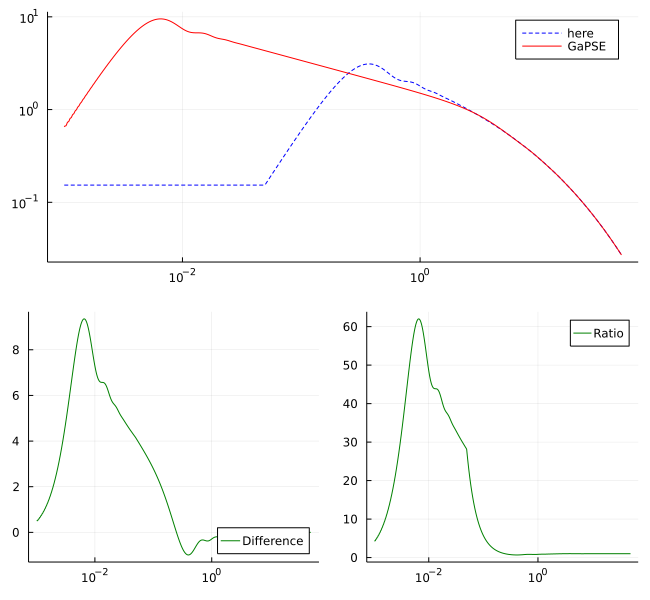

In [17]:
ss = casto_ss;
xs, ys = xicalc(PK, 2, 0; N = 2^12, kmin = 1e-8, kmax = 17, r0 = 1.0/k_max)
spline = Spline1D(xs, ys)

x_min = 1e-3
x_max = 50

new_ss = ss[x_min.< ss .< x_max]
here_ys = spline(ss)[x_min.< ss .< x_max]
gapse_ys = my_I20s[x_min.< ss .< x_max]

p1 = plot([new_ss, new_ss] , 
    [here_ys, gapse_ys],
    xaxis=:log, yaxis=:log,
    lc=[:blue :red], ls=[:dash :solid], labels=["here" "GaPSE"])

p2 = plot(new_ss, gapse_ys .- here_ys, 
    xaxis=:log,label="Difference", lc=:green, legend=:bottomright)
p3 = plot(new_ss, gapse_ys ./ here_ys, xaxis=:log, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )

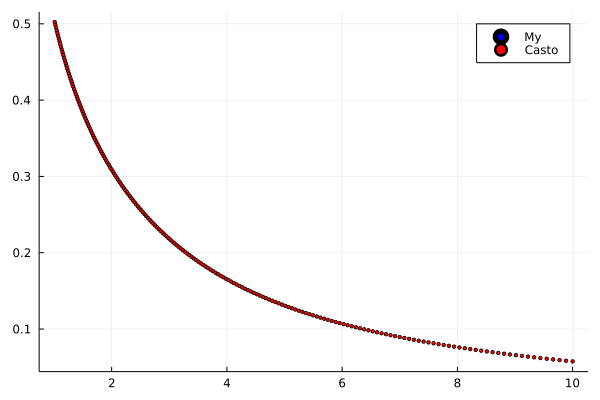

In [19]:
ind = 5

x_min = 1
x_max = 10

new_ss = ss[x_min.< ss .< x_max]
my_ys = my_vec[ind][x_min.< ss .< x_max]
casto_ys = casto_vec[ind][x_min.< ss .< x_max]

scatter( new_ss, my_ys, 
    #xscale=:log10, yscale=:log10,
    label="My", color=:blue, markersize = 1, )

scatter!(new_ss,  casto_ys, 
    #xscale=:log10, yscale=:log10,
    label="Casto", color=:red, markersize = 2)

In [20]:
function derivate_point(xp, yp, x1, y1, x2, y2)
    m2 = (y2 - yp)/(x2 - xp)
    m1 = (yp - y1)/(xp - x1)
    return (m1 + m2)/2.0
end

derivate_point (generic function with 1 method)

In [21]:
function derivate_vector(xs, ys; N::Integer = 1)
    if N == 1
        real_vec = [derivate_point(xs[i], ys[i], xs[i-1], ys[i-1], xs[i+1], ys[i+1]) 
                for i in (N+1):(length(xs)-N)]
        return vcat(real_vec[begin], real_vec, real_vec[end])
    elseif N>1
        vec = [ derivate_point(xs[i], ys[i], xs[i-j], ys[i-j], xs[i+j], ys[i+j]) 
        for i in (N+1):(length(xs)-N), j in 1:N]
        real_vec = [sum(row)/N for row in eachrow(vec)]
        return vcat([real_vec[begin] for i in 1:N], real_vec,
            [real_vec[end] for i in 1:N] )
    else 
        throw(ErrorException(" N must be an integer >1, not $N!"))
    end
end

derivate_vector (generic function with 1 method)

In [22]:
function spectral_index(xs, ys; N::Integer=1)
    derivs = derivate_vector(xs, ys; N=N)
    return [x*d/y for (x,y,d) in zip(xs, ys, derivs)]
end

spectral_index (generic function with 1 method)

In [23]:
f(x) = x^1.234

f (generic function with 1 method)

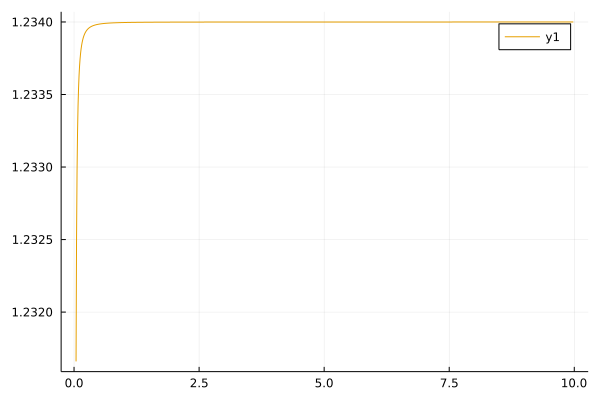

In [24]:
xs = 0:0.01:10;
ys = f.(xs)
plot(xs[5:end-2], spectral_index(xs, ys)[5:end-2])

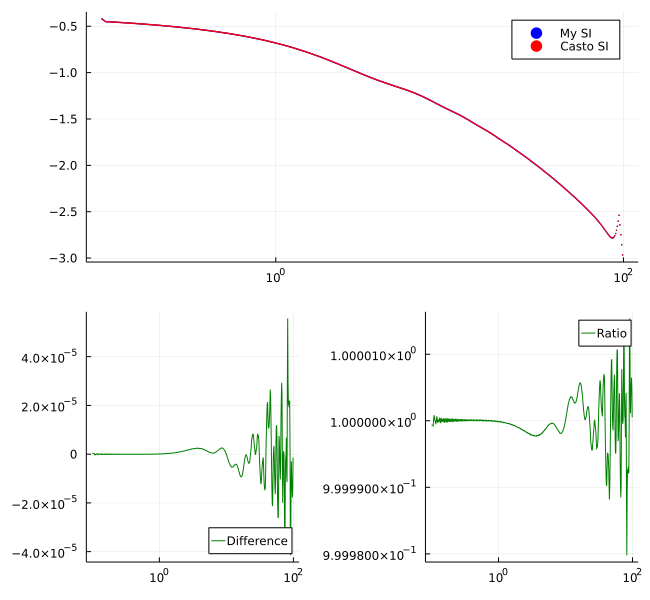

In [25]:
ind = 7

x_min = 0.1
x_max = 1e2

new_ss = ss[x_min.< ss .< x_max]
my_ys = my_vec[ind][x_min.< ss .< x_max]
casto_ys = casto_vec[ind][x_min.< ss .< x_max]

my_sis = spectral_index(new_ss, my_ys; N=4)
casto_sis = spectral_index(new_ss, casto_ys; N=4)


p1 = scatter( [new_ss, new_ss], [my_sis, casto_sis] ,
    xscale=:log10, #yscale=:log10,
    label=["My SI" "Casto SI"], color=[:blue :red], 
    markersize = [1 1], markerstrokewidth=[0 0] )

p2 = plot(new_ss, casto_sis .- my_sis, 
    xscale=:log10,
    label="Difference", lc=:green, legend=:bottomright)

p3 = plot(new_ss, casto_sis ./ my_sis, xscale=:log10, label="Ratio", lc=:green, )

plot(p1, p2, p3, size=(650, 600), layout= @layout [ x ; y z ] )
